# Линейная регрессия и основные библиотеки Python для анализа данных и научных вычислений

Это задание посвящено линейной регрессии. На примере прогнозирования роста человека по его весу Вы увидите, какая математика за этим стоит, а заодно познакомитесь с основными библиотеками Python, необходимыми для дальнейшего прохождения курса.

**Материалы**

- Лекции данного курса по линейным моделям и градиентному спуску
- [Документация](http://docs.scipy.org/doc/) по библиотекам NumPy и SciPy
- [Документация](http://matplotlib.org/) по библиотеке Matplotlib
- [Документация](http://pandas.pydata.org/pandas-docs/stable/tutorials.html) по библиотеке Pandas
- [Pandas Cheat Sheet](http://www.analyticsvidhya.com/blog/2015/07/11-steps-perform-data-analysis-pandas-python/)
- [Документация](http://stanford.edu/~mwaskom/software/seaborn/) по библиотеке Seaborn

## Задание 1. Первичный анализ данных c Pandas

В этом заданиии мы будем использовать данные [SOCR](http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_Dinov_020108_HeightsWeights) по росту и весу 25 тысяч подростков.

**[1].** Если у Вас не установлена библиотека Seaborn - выполните в терминале команду *conda install seaborn*. (Seaborn не входит в сборку Anaconda, но эта библиотека предоставляет удобную высокоуровневую функциональность для визуализации данных).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import optimize
%matplotlib inline

Считаем данные по росту и весу (*weights_heights.csv*, приложенный в задании) в объект Pandas DataFrame:

In [2]:
data = pd.read_csv('SOCR-HeightWeight.csv', index_col='Index')

In [3]:
data

,Height(Inches),Weight(Pounds)
Index,,
1,65.78331,112.9925
2,71.51521,136.4873
3,69.39874,153.0269
4,68.21660,142.3354
5,67.78781,144.2971
...,...,...
24996,69.50215,118.0312
24997,64.54826,120.1932
24998,64.69855,118.2655


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 1 to 25000
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Height(Inches)  25000 non-null  float64
 1   Weight(Pounds)  25000 non-null  float64
dtypes: float64(2)
memory usage: 585.9 KB


In [5]:
data.describe()

,Height(Inches),Weight(Pounds)
count,25000.000000,25000.000000
mean,67.993114,127.079421
std,1.901679,11.660898
min,60.278360,78.014760
25%,66.704397,119.308675
50%,67.995700,127.157750
75%,69.272958,134.892850
max,75.152800,170.924000


Чаще всего первое, что надо надо сделать после считывания данных - это посмотреть на первые несколько записей. Так можно отловить ошибки чтения данных (например, если вместо 10 столбцов получился один, в названии которого 9 точек с запятой). Также это позволяет познакомиться с данными, как минимум, посмотреть на признаки и их природу (количественный, категориальный и т.д.).

После этого стоит построить гистограммы распределения признаков - это опять-таки позволяет понять природу признака (степенное у него распределение, или нормальное, или какое-то еще). Также благодаря гистограмме можно найти какие-то значения, сильно не похожие на другие - "выбросы" в данных.
Гистограммы удобно строить методом *plot* Pandas DataFrame с аргументом *kind='hist'*.

**Пример.** Построим гистограмму распределения роста подростков из выборки *data*. Используем метод *plot* для DataFrame *data* c аргументами *y='Height'* (это тот признак, распределение которого мы строим)

<Axes: title={'center': 'Height (inch.) distribution'}, ylabel='Frequency'>

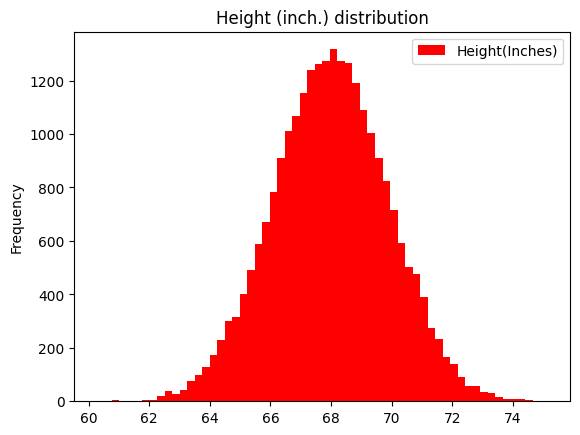

In [6]:
data.plot(y='Height(Inches)', kind='hist', bins=60, color='red',  title='Height (inch.) distribution')

Аргументы:

- *y='Height'* - тот признак, распределение которого мы строим
- *kind='hist'* - означает, что строится гистограмма
- *color='red'* - цвет

**[2]**. Посмотрите на первые 5 записей с помощью метода *head* Pandas DataFrame. Нарисуйте гистограмму распределения веса с помощью метода *plot* Pandas DataFrame. Сделайте гистограмму зеленой, подпишите картинку.

<Axes: ylabel='Frequency'>

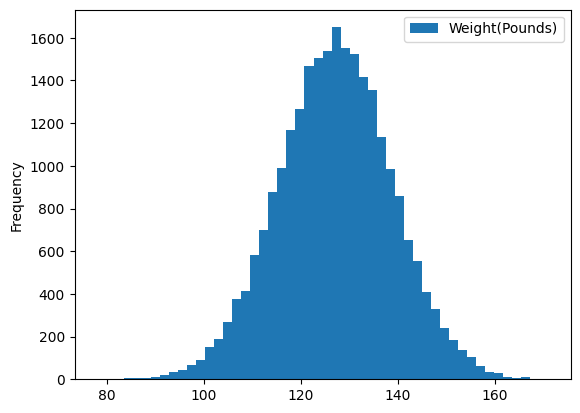

In [7]:
data.plot(y='Weight(Pounds)', kind='hist', bins=50) # строить разноцветные графики, чтобы луче их различать

In [8]:
data.head()

,Height(Inches),Weight(Pounds)
Index,,
1,65.78331,112.9925
2,71.51521,136.4873
3,69.39874,153.0269
4,68.21660,142.3354
5,67.78781,144.2971


<Axes: title={'center': 'Weight (pounds) distribution'}, ylabel='Frequency'>

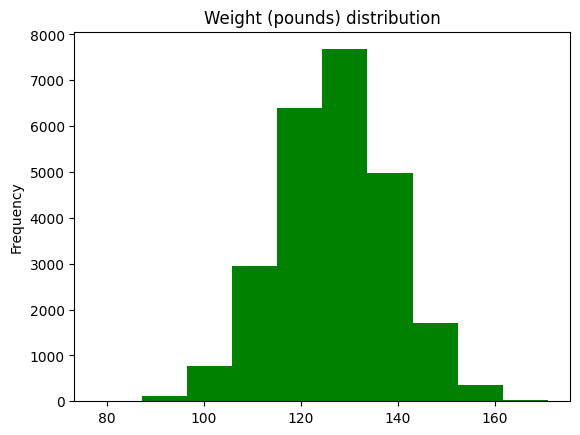

In [10]:
data['Weight(Pounds)'].plot(kind = 'hist', title = 'Weight (pounds) distribution', color = 'green')

Один из эффективных методов первичного анализа данных - отображение попарных зависимостей признаков. Создается $m \times m$ графиков (*m* - число признаков), где по диагонали рисуются гистограммы распределения признаков, а вне диагонали - scatter plots зависимости двух признаков. Это можно делать с помощью метода $scatter\_matrix$ Pandas Data Frame или *pairplot* библиотеки Seaborn.

Чтобы проиллюстрировать этот метод, интересней добавить третий признак. Создадим признак *Индекс массы тела* ([BMI](https://en.wikipedia.org/wiki/Body_mass_index)). Для этого воспользуемся удобной связкой метода *apply* Pandas DataFrame и lambda-функций Python.

In [11]:
def make_bmi(height_inch, weight_pound):
    METER_TO_INCH, KILO_TO_POUND = 39.37, 2.20462
    return (weight_pound / KILO_TO_POUND) / \
           (height_inch / METER_TO_INCH) ** 2

In [12]:
data['BMI'] = data.apply(lambda row: make_bmi(row['Height(Inches)'],
                                              row['Weight(Pounds)']), axis=1)

In [13]:
data.columns

Index(['Height(Inches)', 'Weight(Pounds)', 'BMI'], dtype='object')

In [14]:
data

,Height(Inches),Weight(Pounds),BMI
Index,,,
1,65.78331,112.9925,18.357573
2,71.51521,136.4873,18.762577
3,69.39874,153.0269,22.338895
4,68.21660,142.3354,21.504526
5,67.78781,144.2971,22.077581
...,...,...,...
24996,69.50215,118.0312,17.178982
24997,64.54826,120.1932,20.281866
24998,64.69855,118.2655,19.863971


**[3].** Постройте картинку, на которой будут отображены попарные зависимости признаков , 'Height', 'Weight' и 'BMI' друг от друга. Используйте метод *pairplot* библиотеки Seaborn.

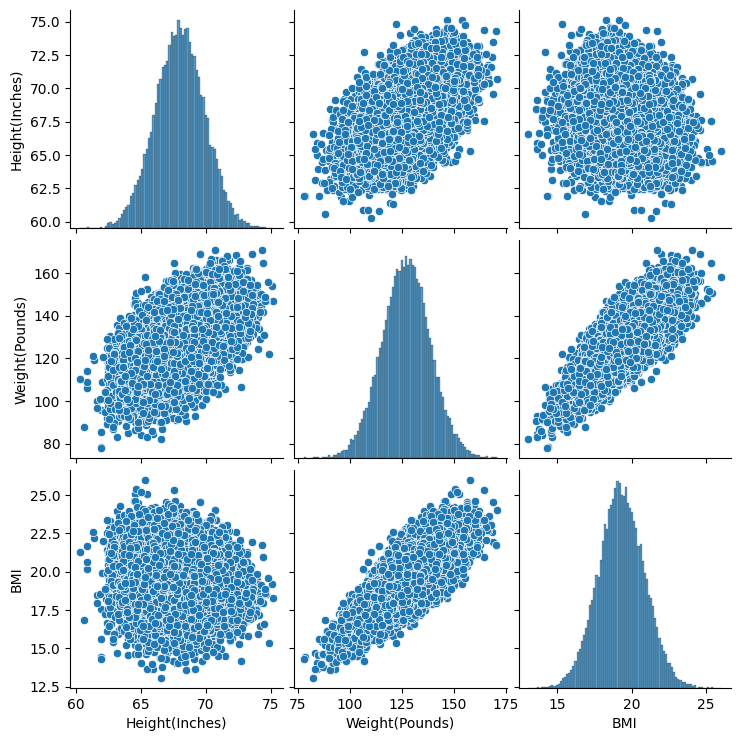

In [15]:
sns.pairplot(data)

Часто при первичном анализе данных надо исследовать зависимость какого-то количественного признака от категориального (скажем, зарплаты от пола сотрудника). В этом помогут "ящики с усами" - boxplots библиотеки Seaborn. Box plot - это компактный способ показать статистики вещественного признака (среднее и квартили) по разным значениям категориального признака. Также помогает отслеживать "выбросы" - наблюдения, в которых значение данного вещественного признака сильно отличается от других.

**[4]**. Создайте в DataFrame *data* новый признак *weight_category*, который будет иметь 3 значения: 1 – если вес меньше 120 фунтов. (~ 54 кг.), 3 - если вес  больше или равен 150 фунтов (~68 кг.), 2 – в остальных случаях. Постройте «ящик с усами» (boxplot), демонстрирующий зависимость роста от весовой категории. Используйте метод *boxplot* библиотеки Seaborn и метод *apply* Pandas DataFrame. Подпишите ось *y* меткой «Рост», ось *x* – меткой «Весовая категория».

[Text(0, 0.5, 'Рост'), Text(0.5, 0, 'Весовая категория')]

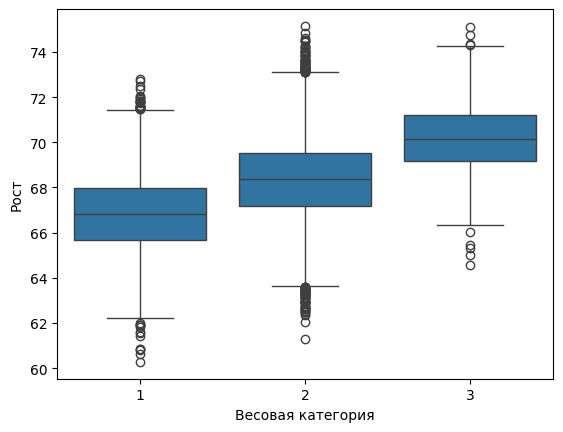

In [16]:
def weight_category(weight):
    weight_category = None
    if weight < 120:
        weight_category = 1
    elif weight >= 150:
        weight_category = 3
    else:
        weight_category = 2
    return weight_category

data['weight_cat'] = data['Weight(Pounds)'].apply(weight_category)
ax = sns.boxplot(data = data, x = 'weight_cat', y = 'Height(Inches)')
ax.set(ylabel = u'Рост', xlabel = u'Весовая категория')

**[5].** Постройте scatter plot зависимости роста от веса, используя метод *plot* для Pandas DataFrame с аргументом *kind='scatter'*. Подпишите картинку.

[Text(0.5, 0, 'Вес'), Text(0, 0.5, 'Рост')]

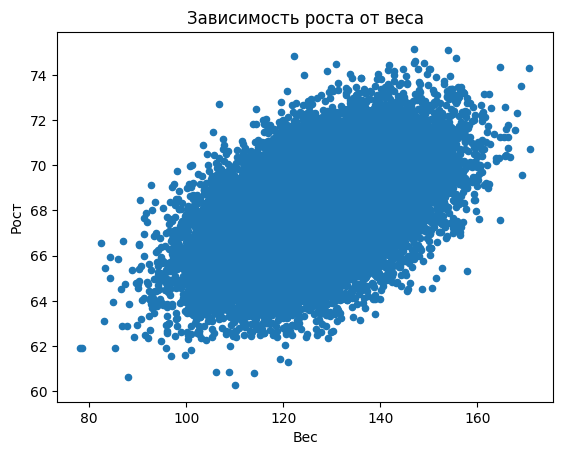

In [17]:
ax = data.plot(kind = 'scatter', x = 'Weight(Pounds)', y = 'Height(Inches)', title = u'Зависимость роста от веса')
ax.set(xlabel = u'Вес', ylabel = u'Рост')

## Задание 2. Минимизация квадратичной ошибки

В простейшей постановке задача прогноза значения вещественного признака по прочим признакам (задача восстановления регрессии) решается минимизацией квадратичной функции ошибки.

**[6].** Напишите функцию, которая по двум параметрам $w_0$ и $w_1$ вычисляет квадратичную ошибку приближения зависимости роста $y$ от веса $x$ прямой линией $y = w_0 + w_1 * x$:
$$error(w_0, w_1) = \sum_{i=1}^n {(y_i - (w_0 + w_1 * x_i))}^2 $$
Здесь $n$ – число наблюдений в наборе данных, $y_i$ и $x_i$ – рост и вес $i$-ого человека в наборе данных.

In [18]:
def get_y(w0, w1, x):
    return w0 + w1*x

def get_error(w0, w1):
    return sum(map(lambda x, y: (y - get_y(w0, w1, x)) ** 2, data['Weight(Pounds)'], data['Height(Inches)']))

Итак, мы решаем задачу: как через облако точек, соответсвующих наблюдениям в нашем наборе данных, в пространстве признаков "Рост" и "Вес" провести прямую линию так, чтобы минимизировать функционал из п. 6. Для начала давайте отобразим хоть какие-то прямые и убедимся, что они плохо передают зависимость роста от веса.

**[7].** Проведите на графике из п. 5 Задания 1 две прямые, соответствующие значениям параметров ($w_0, w_1) = (60, 0.05)$ и ($w_0, w_1) = (50, 0.16)$. Используйте метод *plot* из *matplotlib.pyplot*, а также метод *linspace* библиотеки NumPy. Подпишите оси и график.

In [19]:
def make_model_plot(w_values):
    ax = data.plot(kind = 'scatter', y = 'Height(Inches)', x = 'Weight(Pounds)', title = u'Зависимость роста от веса')
    ax.set(xlabel = u'Вес', ylabel = u'Рост')
    plt.xlim(40, 200)
    plt.ylim(50, 85)

    colors = ['red', 'green', 'blue', 'black', 'orange']
    colors.reverse()
    x_range = np.linspace(40, 200, 1000)
    for w0, w1 in w_values:
        y = list(map(lambda p: get_y(w0, w1, p), x_range))
        color = colors.pop()

        plt.plot(x_range, y, color = color, lw = 2)

In [20]:
data.columns

Index(['Height(Inches)', 'Weight(Pounds)', 'BMI', 'weight_cat'], dtype='object')

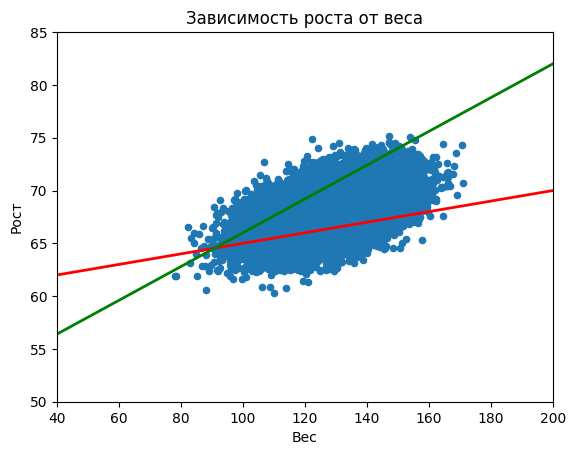

In [21]:
make_model_plot([(60, 0.05), (50, 0.16)])

Минимизация квадратичной функции ошибки - относительная простая задача, поскольку функция выпуклая. Для такой задачи существует много методов оптимизации. Посмотрим, как функция ошибки зависит от одного параметра (наклон прямой), если второй параметр (свободный член) зафиксировать.

**[8].** Постройте график зависимости функции ошибки, посчитанной в п. 6, от параметра $w_1$ при $w_0$ = 50. Подпишите оси и график.

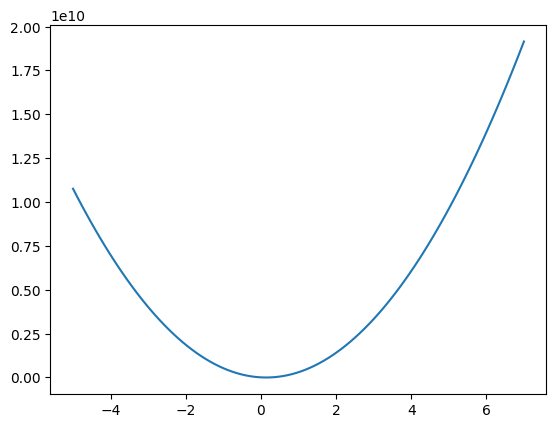

In [22]:
w0 = 50
w1 = np.linspace(-5, 7, 100)
error = list(map(lambda p: get_error(w0, p), w1))

plt.plot(w1, error)

Теперь методом оптимизации найдем "оптимальный" наклон прямой, приближающей зависимость роста от веса, при фиксированном коэффициенте $w_0 = 50$.

**[9].** С помощью метода *minimize_scalar* из *scipy.optimize* найдите минимум функции, определенной в п. 6, для значений параметра  $w_1$ в диапазоне [-5,5]. Проведите на графике из п. 5 Задания 1 прямую, соответствующую значениям параметров ($w_0$, $w_1$) = (50, $w_1\_opt$), где $w_1\_opt$ – найденное в п. 8 оптимальное значение параметра $w_1$.

w1_opt = 0.1411


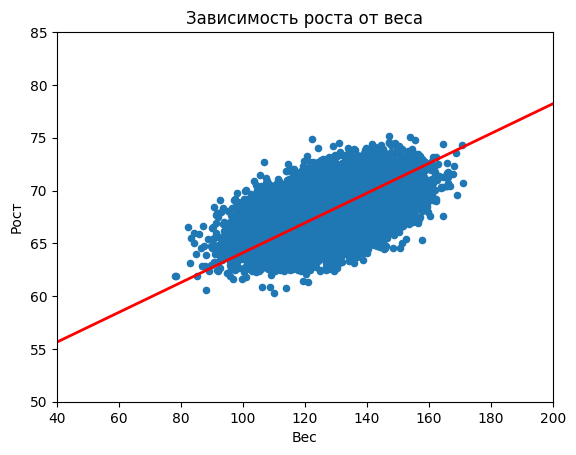

In [23]:
w0 = 50
w1_opt = optimize.minimize_scalar(lambda x: get_error(w0, x), bounds = [-5, 5]).x
print('w1_opt = %.4f' % w1_opt)

make_model_plot([(w0, w1_opt)])

При анализе многомерных данных человек часто хочет получить интуитивное представление о природе данных с помощью визуализации. Увы, при числе признаков больше 3 такие картинки нарисовать невозможно. На практике для визуализации данных в 2D и 3D в данных выделаяют 2 или, соответственно, 3 главные компоненты (как именно это делается - мы увидим далее в курсе) и отображают данные на плоскости или в объеме.

Посмотрим, как в Python рисовать 3D картинки, на примере отображения функции $z(x,y) = sin(\sqrt{x^2+y^2})$ для значений $x$ и $y$ из интервала [-5,5] c шагом 0.25.

In [24]:
from mpl_toolkits.mplot3d import Axes3D

Создаем объекты типа matplotlib.figure.Figure (рисунок) и  matplotlib.axes._subplots.Axes3DSubplot (ось).

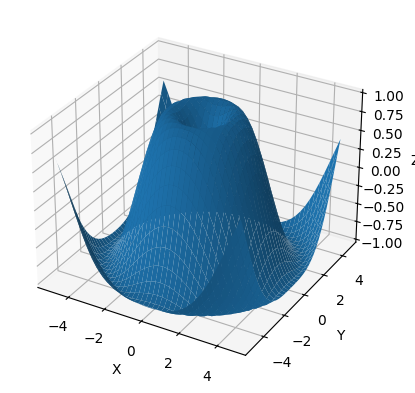

In [25]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d') # get current axis

# Создаем массивы NumPy с координатами точек по осям X и У.
# Используем метод meshgrid, при котором по векторам координат
# создается матрица координат. Задаем нужную функцию Z(x, y).
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
Z = np.sin(np.sqrt(X**2 + Y**2))

# Наконец, используем метод *plot_surface* объекта
# типа Axes3DSubplot. Также подписываем оси.
surf = ax.plot_surface(X, Y, Z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [26]:
np.meshgrid(X, Y)

(array([[-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
        [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
        [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
        ...,
        [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
        [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75],
        [-5.  , -4.75, -4.5 , ...,  4.25,  4.5 ,  4.75]]),
 array([[-5.  , -5.  , -5.  , ..., -5.  , -5.  , -5.  ],
        [-5.  , -5.  , -5.  , ..., -5.  , -5.  , -5.  ],
        [-5.  , -5.  , -5.  , ..., -5.  , -5.  , -5.  ],
        ...,
        [ 4.75,  4.75,  4.75, ...,  4.75,  4.75,  4.75],
        [ 4.75,  4.75,  4.75, ...,  4.75,  4.75,  4.75],
        [ 4.75,  4.75,  4.75, ...,  4.75,  4.75,  4.75]]))

**[10].** Постройте 3D-график зависимости функции ошибки, посчитанной в п.6 от параметров $w_0$ и $w_1$. Подпишите ось $x$ меткой «Intercept», ось $y$ – меткой «Slope», a ось $z$ – меткой «Error».

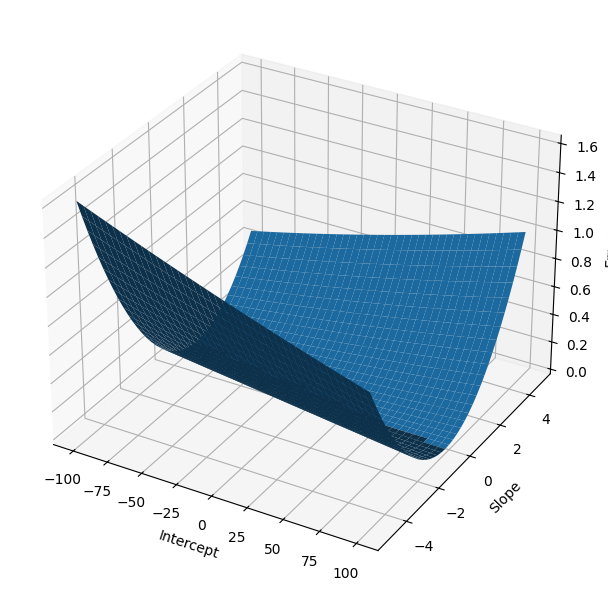

In [27]:
fig = plt.figure()
fig.set_size_inches(13.5, 7.5)
ax = fig.add_subplot(projection='3d') # get current axis

# Создаем массивы NumPy с координатами точек по осям X и У.
# Используем метод meshgrid, при котором по векторам координат
# создается матрица координат. Задаем нужную функцию Z(x, y).
W0 = np.arange(-100, 101, 1)
W1 = np.arange(-5, 5, 0.25)
W0, W1 = np.meshgrid(W0, W1)
ERR = get_error(W0, W1)

# # Наконец, используем метод *plot_surface* объекта
# # типа Axes3DSubplot. Также подписываем оси.
surf = ax.plot_surface(W0, W1, ERR)
ax.set_xlabel('Intercept')
ax.set_ylabel('Slope')
ax.set_zlabel('Error')

plt.show()

**[11].** С помощью метода *minimize* из scipy.optimize найдите минимум функции, определенной в п. 6, для значений параметра $w_0$ в диапазоне [-100,100] и $w_1$ - в диапазоне [-5, 5]. Начальная точка – ($w_0$, $w_1$) = (0, 0). Используйте метод оптимизации L-BFGS-B (аргумент method метода minimize). Проведите на графике из п. 5 Задания 1 прямую, соответствующую найденным оптимальным значениям параметров $w_0$ и $w_1$. Подпишите оси и график.

w0_opt = 57.5717, w1_opt = 0.0820


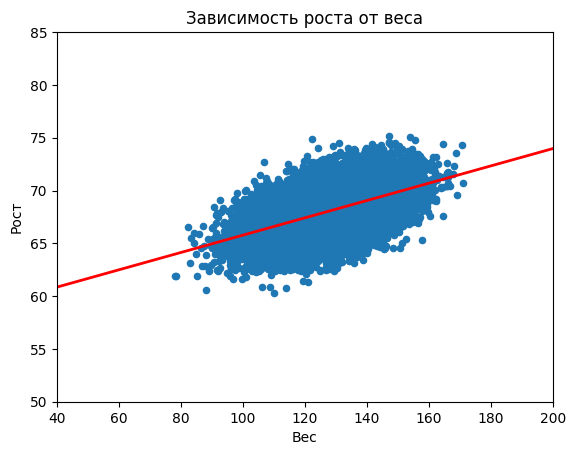

In [28]:
def get_error_opt(w):
    return get_error(w[0], w[1])

w0_opt, w1_opt = optimize.minimize(get_error_opt, (0,0), bounds = [(-100, 100), (-5, 5)], method = 'L-BFGS-B').x
print('w0_opt = %.4f, w1_opt = %.4f' % (w0_opt, w1_opt))

make_model_plot([(w0_opt, w1_opt)])

In [29]:
data[['Height(Inches)', 	'Weight(Pounds)', 	'BMI', 	'weight_cat']]

,Height(Inches),Weight(Pounds),BMI,weight_cat
Index,,,,
1,65.78331,112.9925,18.357573,1
2,71.51521,136.4873,18.762577,2
3,69.39874,153.0269,22.338895,3
4,68.21660,142.3354,21.504526,2
5,67.78781,144.2971,22.077581,2
...,...,...,...,...
24996,69.50215,118.0312,17.178982,1
24997,64.54826,120.1932,20.281866,2
24998,64.69855,118.2655,19.863971,1


<Axes: >

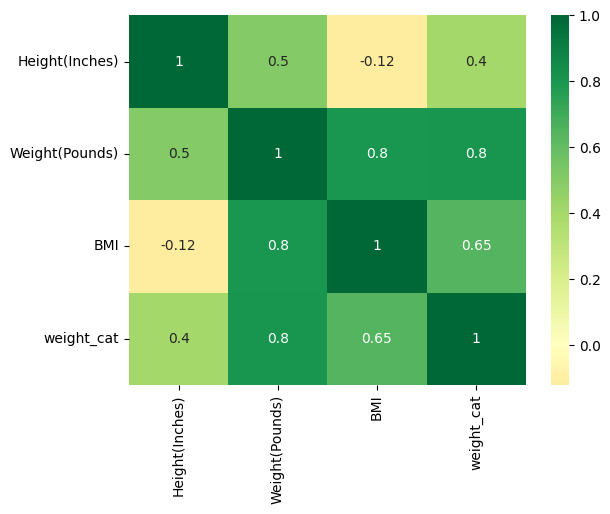

In [30]:
df = data[['Height(Inches)', 	'Weight(Pounds)', 	'BMI', 	'weight_cat']]
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)

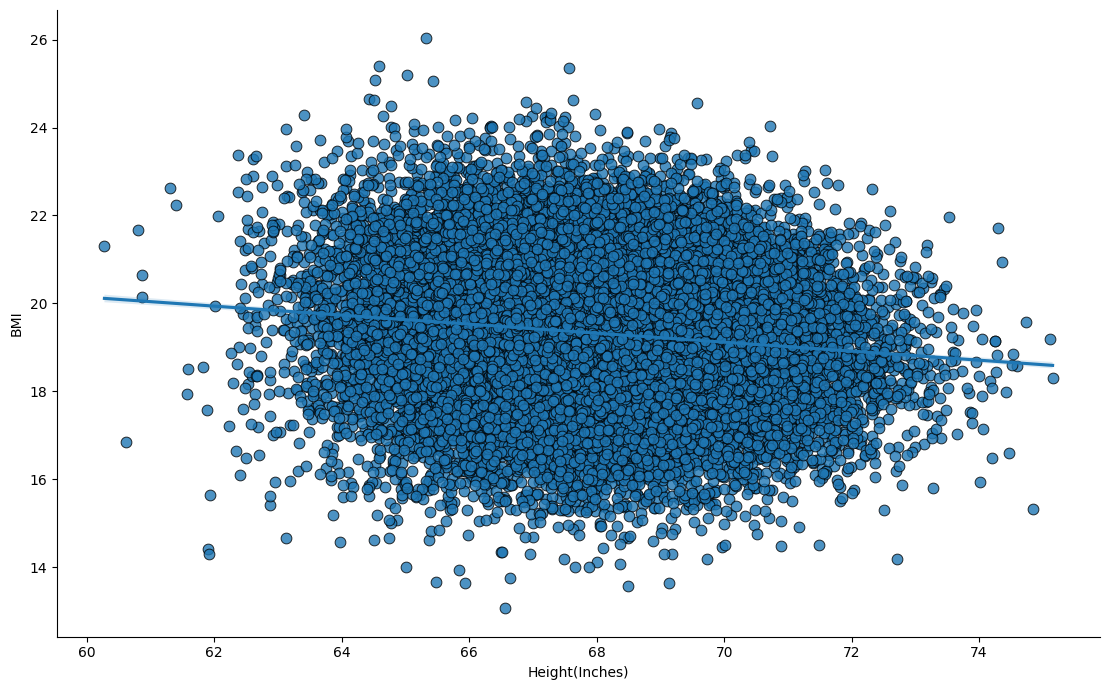

In [31]:
gridobj = sns.lmplot(x="Height(Inches)", y="BMI",  data=data,
                     height=7, aspect=1.6, robust=True, palette='tab10',
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))

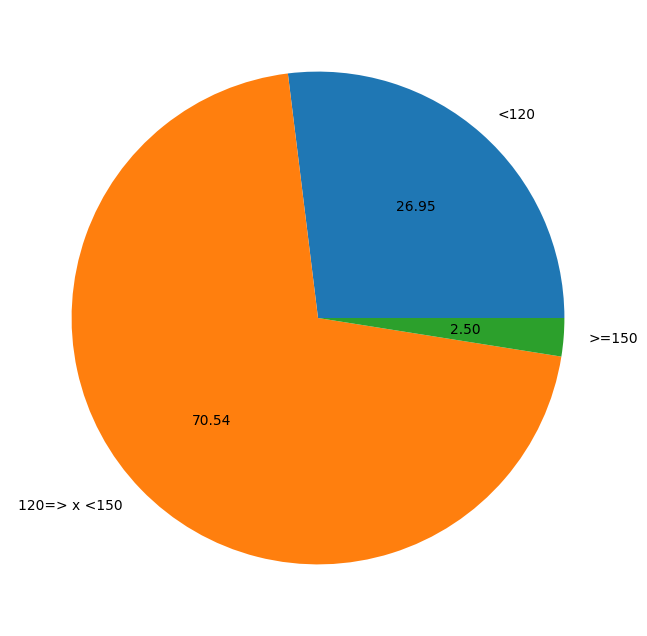

In [32]:
df = data.groupby('weight_cat').size()


df.plot(kind='pie', subplots=True, figsize=(8, 8),
        labels=['<120', '120=> x <150', '>=150'], autopct='%.2f')

plt.show()


In [ ]:
# plt.figure(figsize=(13,10), dpi= 80)
# sns.violinplot(x='Height(Inches)', y='BMI', data=data, scale='width', inner='quartile')


In [34]:
w_150 = data[(data['Weight(Pounds)'] > 140)]
w_150
# df.loc[df['shield'] > 6]

,Height(Inches),Weight(Pounds),BMI,weight_cat
Index,,,,
3,69.39874,153.0269,22.338895,3
4,68.21660,142.3354,21.504526,2
5,67.78781,144.2971,22.077581,2
7,69.80204,141.4947,20.417428,2
18,68.64927,142.9733,21.329476,2
...,...,...,...,...
24979,69.62400,141.5823,20.534688,2
24981,69.79922,154.4399,22.287197,3
24988,68.86794,142.8494,21.175873,2


/tmp/ipykernel_6028/2939886027.py:2: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(y='Height(Inches)', x='weight_cat', data=w_150, scale='width', inner='quartile')


<Axes: xlabel='weight_cat', ylabel='Height(Inches)'>

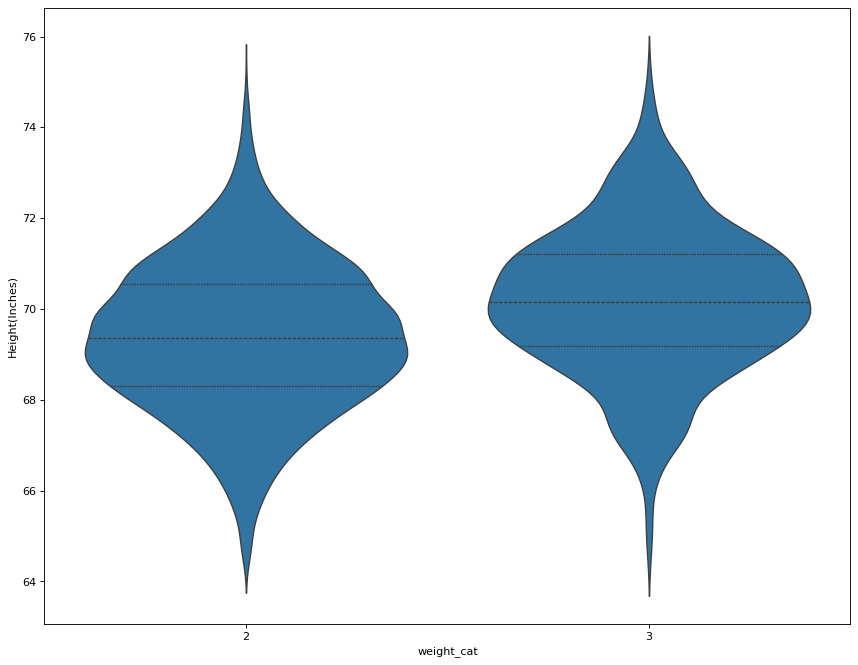

In [35]:
plt.figure(figsize=(13,10), dpi= 80)
sns.violinplot(y='Height(Inches)', x='weight_cat', data=w_150, scale='width', inner='quartile')

/tmp/ipykernel_6028/2198751530.py:2: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(y='Height(Inches)', x='weight_cat', data=data, scale='width', inner='quartile')


<Axes: xlabel='weight_cat', ylabel='Height(Inches)'>

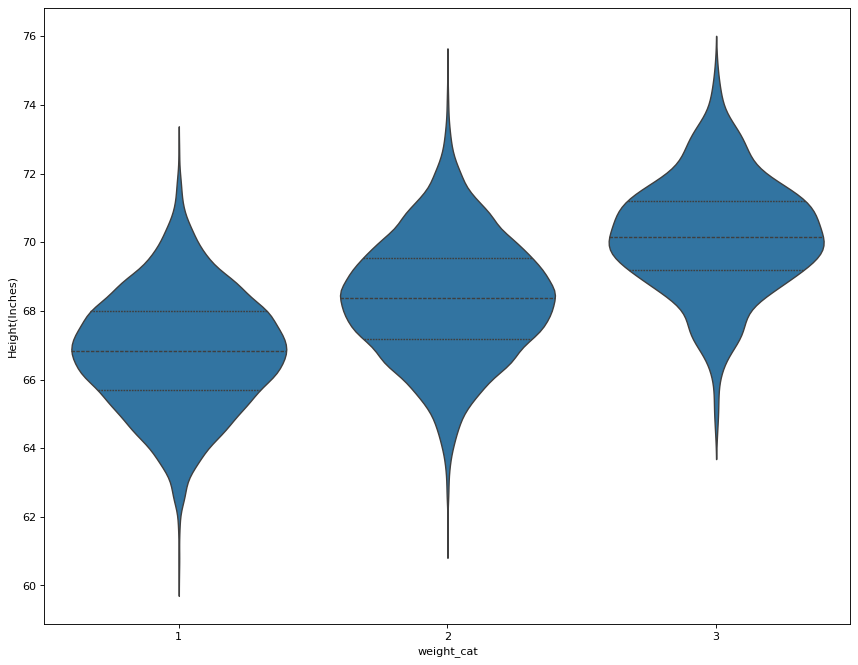

In [36]:
plt.figure(figsize=(13,10), dpi= 80)
sns.violinplot(y='Height(Inches)', x='weight_cat', data=data, scale='width', inner='quartile')